# Clustering de documents

In [ ]:
# TP3
# copie de s2_clustering du module4

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaeld\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [6]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [7]:
# Exemple de fichiers
files[:5]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt']

In [9]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [10]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [11]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [13]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [14]:
# Détail de la matrice
tfidf_vectors.shape

(1000, 3508)

### Imprimer le vecteur tf-IDF du premier document

In [15]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

parti           0.276899
loyer           0.152155
janvier         0.147985
populaire       0.147400
propriétaire    0.143646
                  ...   
ent             0.000000
entend          0.000000
enthousiasme    0.000000
entier          0.000000
italiens        0.000000
Length: 3508, dtype: float64

## Comprendre les vecteurs et leurs "distances"

### Tests sur nos documents

In [16]:
tfidf_array = tfidf_vectors.toarray()

In [17]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03783208])

In [18]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.00670198, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [19]:
cosine(tfidf_array[0], tfidf_array[1])

0.931459087039414

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [20]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [21]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [22]:
clusters = km_model.fit_predict(tfidf_vectors)

In [23]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [24]:
pprint(dict(clustering))

{0: ['KB_JB838_1950-01-06_01-00002.txt',
     'KB_JB838_1950-01-15_01-00010.txt',
     'KB_JB838_1950-02-15_01-00014.txt',
     'KB_JB838_1950-02-17_01-00009.txt',
     'KB_JB838_1950-02-18_01-00009.txt',
     'KB_JB838_1950-03-01_01-00005.txt',
     'KB_JB838_1950-03-05_01-00020.txt',
     'KB_JB838_1950-03-11_01-00005.txt',
     'KB_JB838_1950-03-19_01-00001.txt',
     'KB_JB838_1950-03-25_01-00009.txt',
     'KB_JB838_1950-03-27_01-00002.txt',
     'KB_JB838_1950-03-29_01-00002.txt',
     'KB_JB838_1950-03-31_01-00006.txt',
     'KB_JB838_1950-04-19_01-00002.txt',
     'KB_JB838_1950-04-26_01-00007.txt',
     'KB_JB838_1950-05-07_01-00002.txt',
     'KB_JB838_1950-05-16_01-00003.txt',
     'KB_JB838_1950-05-29_01-00002.txt',
     'KB_JB838_1950-06-04_01-00011.txt',
     'KB_JB838_1950-06-10_01-00010.txt',
     'KB_JB838_1950-06-11_01-00001.txt',
     'KB_JB838_1950-06-22_01-00004.txt',
     'KB_JB838_1950-06-29_01-00002.txt',
     'KB_JB838_1950-07-02_01-00002.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [25]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [26]:
reduced_vectors[:10]

array([[-0.32605256,  0.11352953],
       [ 0.11443706, -0.3012154 ],
       [ 0.44374749, -0.25183461],
       [-0.2392338 , -0.03686026],
       [-0.05219372, -0.10413462],
       [ 0.61193695,  0.50552431],
       [-0.20445202, -0.03419313],
       [-0.19508297, -0.03696722],
       [ 0.62322593,  0.45733879],
       [ 0.15728827, -0.01517503]])

### Générer le plot

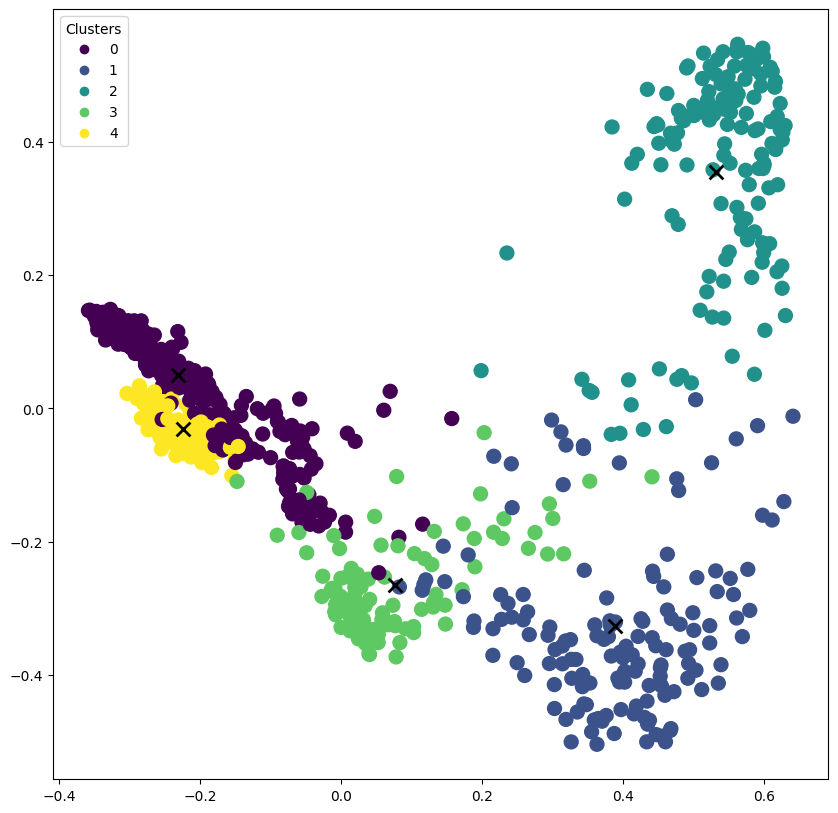

In [27]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")